## 基于MindSpore实现二维线性回归

本实验将实现基于MindSpore的二维线性回归，包括人造数据集、模型构建、模型预测。

### 1、实验目的
- 掌握如何使用MindSpore实现二维线性回归模型。
- 了解如何使用MindSpore的Adam优化器和MSE损失函数
- 了解基于MindSpore的模型训练和模型预测

### 2、整体模型介绍
- 二维线性回归原理

在机器学习领域，线性回归模型记为：
$$y=w_0x_0+w_1x_1+\cdots+w_nx_n+b=[w_0 w_1 w_2 \cdots w_n][x_0 x_1 x_2 \cdots x_n]^T+b$$
可以统一形式为：
$$y=\sum_{i=0}^{n}w_ix_i+b=w^Tx+b$$


并且我们定义损失函数来度量模型一次预测的好坏，即预测值$\widehat y$和真实值y的误差，线性损失函数一般取$L=\frac{1}{2}(y-\widehat y)^2$，平方损失函数的几何意义是欧氏距离。

之后我们便可进行模型训练，采用梯度下降方法求模型参数w，使损失函数最小。

梯度下降法顺着当前点梯度反方向，按规定步长$\alpha$进行迭代搜索，对第i个模型参数进行如下更新：
$$w_{i+1}=w_i-\alpha \frac{\partial L(w)}{\partial (w_i)}$$
因为
$$\frac{\partial L(w)}{\partial (w_i)}=-\sum_{j=0}^{m}[y^{(j)}-\sum_{i=0}^{n}w_i x_i^{(j)}-b]*x_i^{(j)}$$
所以
$$w_{i+1}=w_i+\alpha [\sum_{j=0}^{m}(y^{(j)}-\sum_{i=0}^{n}w_i x_i^{(j)}-b)*x_i^{(j)}]$$
对每个模型参数迭代训练直到收敛即可。因此二维线性回归的自变量为两个，模型便为：
$$y=w_0x_0+w_1x_1+b=w^Tx+b$$

因此我们需要定义一个模型Net实现二维线性回归功能。<br>
可以调用MindSpore的nn.MSELoss计算预测值和目标值之间的均方误差。<br>
调用MindSpore的nn.Adam计算最优参数。

### 3 实验环境
在动手进行实践之前，需要注意以下几点：
* 确保实验环境正确安装，包括安装MindSpore。安装过程：首先登录[MindSpore官网安装页面](https://www.mindspore.cn/install)，根据安装指南下载安装包及查询相关文档。同时，官网环境安装也可以按下表说明找到对应环境搭建文档链接，根据环境搭建手册配置对应的实验环境。
* 推荐使用交互式的计算环境Jupyter Notebook，其交互性强，易于可视化，适合频繁修改的数据分析实验环境。
* 实验也可以在华为云一站式的AI开发平台ModelArts上完成。
* 推荐实验环境：MindSpore版本=2.0；Python环境=3.7


|  硬件平台 |  操作系统  | 软件环境 | 开发环境 | 环境搭建链接 |
| :-----:| :----: | :----: |:----:   |:----:   |
| CPU | Windows-x64 | MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.1节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| GPU CUDA 10.1|Linux-x86_64| MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.2节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| Ascend 910  | Linux-x86_64| MindSpore2.0 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第四章](./MindSpore环境搭建实验手册.docx)|


### 4、数据处理
#### 4.1 数据准备
为了简单起见，我们将根据带有噪声的线性模型构造一个人造数据集。任务是使用这个有限样本的数据集来恢复这个模型的参数。我们需要生成一个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。 合成的数据集是一个矩阵$X∈R^{(1000×2)}$。我们使用线性模型参数$w =[2,-3.4]^T$、b=3.2和噪声项$\epsilon$生成数据集及其标签：
$y=Xw+b+\epsilon=w_0x_0+w_1x_1+b+\epsilon$

$\epsilon$可以视为模型预测和标签之间的观测误差，我们假设ϵ服从均值为0、标准差为0.01的正态分布。


random库实现了各种分布的伪随机数生成器；dtype是MindSpore数据类型的对象；mindspore.ops提供对神经网络层的各种操作；pyplot是常用的绘图模块，能很方便让用户绘制 2D 图表；mindspore中的Tensor是张量，可放在gpu上加速。

In [1]:
import random
import numpy as np
import mindspore
from mindspore import dtype as mstype
import mindspore.ops as ops
from matplotlib import pyplot as plt
import sys
sys.path.append('..')

In [2]:
def synthetic_data(w, b, num_examples):  
    print((num_examples, len(w)))
    # 生成X
    X = np.random.normal(0, 1, (num_examples, len(w))).astype(np.float32)
    # y = Xw + b
    y = np.matmul(X, w) + b 
    # y = Xw + b + 噪声。
    y += np.random.normal(0, 0.01, len(y)).astype(np.float32)          
    return X, y.reshape((-1, 1))

mindspore.set_seed(1)
true_w = np.array([2, -3.4]).astype(np.float32)
true_b = np.float32(4.2)
# 人造数据
features, labels = synthetic_data(true_w, true_b, 1000)

(1000, 2)


#### 4.2 数据加载
数据features中的每一行都包含一个二维数据样本，真实值labels中的每一行都包含一维标签值（一个标量）

In [3]:
print('features:', features[0:4],'\nlabel:', labels[0:4])

features: [[ 1.6243454  -0.6117564 ]
 [-0.5281718  -1.0729686 ]
 [ 0.86540765 -2.3015387 ]
 [ 1.7448118  -0.7612069 ]] 
label: [[ 9.533557]
 [ 6.794138]
 [13.751566]
 [10.271619]]


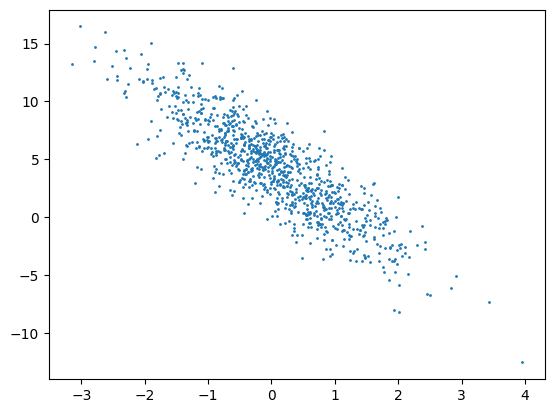

In [4]:
# 画出第二个特征与真实值的散点图
plt.scatter(features[:, (1)], labels, 1); 
plt.show()

使用MindSpore的GeneratorDataset创建可迭代数据。<br>
dataset模块提供了加载和处理数据集的API；numpy提供了一系列类NumPy接口。

In [5]:
from mindspore import dataset as ds  

class DatasetGenerator:
    def __init__(self):
        self.data = features
        self.label = labels

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)
        
batch_size = 10
dataset_generator = DatasetGenerator()
dataset = ds.GeneratorDataset(dataset_generator, ["data", "label"], shuffle=True)
# 将数据集中连续10条数据合并为一个批处理数据
dataset = dataset.batch(batch_size)                

### 5、模型构建

模型构建分为定义实现二维线性回归功能的Net、用于计算预测值与标签值之间的均方误差MSELoss、Adam优化器。
- 定义模型Net

Net输入为X样本，计算出预测值$\widehat y$并返回。<br>
mindspore.nn用于构建神经网络中的预定义构建块或计算单元；Parameter 是 Tensor 的子类，当它们被绑定为Cell的属性时，会自动添加到其参数列表中，并且可以通过Cell的某些方法获取；mindspore.common.initializer用于初始化神经元参数。

In [6]:
import mindspore.nn as nn
from mindspore import Parameter
from mindspore.common.initializer import initializer, Zero, Normal


def linreg(x, w, b):
    # y = Xw+b
    return ops.matmul(x, w) + b    


class Net(nn.Cell):
    def __init__(self):
        super().__init__()
        self.w = Parameter(initializer(Normal(0.01, 0), (2, 1), mstype.float32))
        self.b = Parameter(initializer(Zero(), 1, mstype.float32))
        
    def construct(self, x):
        # y_hat = Xw+b
        y_hat = linreg(x, self.w, self.b)  
        return y_hat
    
    
# Net用于实现二维线性回归
net = Net()

- 使用MSE损失函数和Adam优化器

In [7]:
# 训练的eopch为3
num_epochs = 3
# 学习率为0.03
lr = 0.03
# Adam优化器
optim = nn.Adam(net.trainable_params(), learning_rate=lr)          
# 计算预测值与标签值之间的均方误差
loss = nn.MSELoss()   

### 6、模型训练
Model是模型训练与推理的高阶接口，调用Model.train方法，传入数据集即可完成模型训练，其中LossMonitor()会监控训练的损失，并将epoch、step、loss信息打印出来，若loss变为NAN或INF，则会终止训练。

In [8]:
from mindspore.train import Model                                       
from mindspore.train import LossMonitor 

In [9]:
# 模型训练或推理的高阶接口。Model 会根据用户传入的参数封装可训练或推理的实例
model = Model(net, loss_fn=loss, optimizer=optim)  
# 模型训练接口。训练场景下，LossMonitor监控训练的loss；边训练边推理场景下，监控训练的loss和推理的metrics。如果loss是NAN或INF，则终止训练
model.train(num_epochs, dataset, callbacks=[LossMonitor()])  

epoch: 1 step: 1, loss is 29.33513832092285
epoch: 1 step: 2, loss is 37.46299743652344
epoch: 1 step: 3, loss is 39.28642272949219
epoch: 1 step: 4, loss is 41.847991943359375
epoch: 1 step: 5, loss is 16.808752059936523
epoch: 1 step: 6, loss is 42.482215881347656
epoch: 1 step: 7, loss is 29.145341873168945
epoch: 1 step: 8, loss is 33.21084213256836
epoch: 1 step: 9, loss is 30.48308563232422
epoch: 1 step: 10, loss is 27.18667221069336
epoch: 1 step: 11, loss is 41.479427337646484
epoch: 1 step: 12, loss is 50.3975715637207
epoch: 1 step: 13, loss is 17.694313049316406
epoch: 1 step: 14, loss is 35.32475280761719
epoch: 1 step: 15, loss is 51.93513870239258
epoch: 1 step: 16, loss is 18.89722442626953
epoch: 1 step: 17, loss is 30.43497657775879
epoch: 1 step: 18, loss is 25.525924682617188
epoch: 1 step: 19, loss is 30.582584381103516
epoch: 1 step: 20, loss is 12.64999771118164
epoch: 1 step: 21, loss is 31.38129425048828
epoch: 1 step: 22, loss is 19.548561096191406
epoch: 1 st

### 7、模型预测
训练3个epoch后输出w和b的估计误差，比较真实参数和通过训练学到的参数来评估训练的成功程度。

In [10]:
# w的真实值和训练值之差
print(f'w的估计误差: {true_w - net.trainable_params()[0].reshape(true_w.shape)}')  
# b的真实值和训练值之差
print(f'b的估计误差: {true_b - net.trainable_params()[1]}')                        

w的估计误差: [Tensor(shape=[], dtype=Float32, value= -0.0121365)
 Tensor(shape=[], dtype=Float32, value= -0.0563698)]
b的估计误差: [Tensor(shape=[], dtype=Float32, value= 0.0883765)]
